In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install torch torchvision albumentations opencv-python gradio

In [ ]:
!pip install git+https://github.com/ChristophReich1996/Involution

  Cloning https://github.com/ChristophReich1996/Involution to /tmp/pip-req-build-d9056ery
  Running command git clone --filter=blob:none --quiet https://github.com/ChristophReich1996/Involution /tmp/pip-req-build-d9056ery
  Resolved https://github.com/ChristophReich1996/Involution to commit a3b9ba3f00cb350aa8d94b2a5b0057a28a0892ef
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torchvision import datasets, transforms
from torch.optim import *

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import cv2
import glob
import copy

from sklearn.model_selection import train_test_split
#import wandb

from torchsummary import summary

from skimage.feature import hog
from tqdm import tqdm as tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 42

from numba import jit, cuda

from torch.utils.data import TensorDataset, DataLoader, Dataset

from PIL import Image
import glob

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 as ToTensor

from involution import Involution2d


In [ ]:
class Block_en(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.inonv1 = Involution2d(in_channels=in_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.inonv2 = Involution2d(in_channels=out_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))

    def forward(self, x):
        #return self.relu(self.conv2(self.relu(self.conv1(x))))
        #print(self.inonv1(x).shape)
        return self.relu(self.conv2(self.relu(self.inonv1(x))))
        #return self.relu(self.inonv2(self.relu(self.inonv1(x))))

In [ ]:
def dehaze_image(hazy_image, model, transform):
    mask_dummy = np.zeros_like(hazy_image)
    transformed = transform(image=hazy_image, mask=mask_dummy)
    hazy_image_transformed = transformed['image']

    model.eval()
    with torch.no_grad():
        hazy_image_tensor = hazy_image_transformed.clone().detach().to(device).unsqueeze(0)
        model = model.to(device)
        pred_mask_tensor = model(hazy_image_tensor)
        pred_mask_tensor_final = torch.reshape(pred_mask_tensor, hazy_image_tensor.shape)

        # Remove the multiplication by 255 and cast to uint8
        pred_mask = (np.clip(pred_mask_tensor_final.detach().cpu().squeeze(0).permute(1, 2, 0).numpy(), 0, 1) * 255).astype('uint8')

    return pred_mask


In [ ]:
class Block_de(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        #self.inonv1 = Involution2d(in_channels=in_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        #self.inonv2 = Involution2d(in_channels=out_ch, out_channels=out_ch, kernel_size = (3,3), padding = (1,1))

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
        #print(self.inonv1(x).shape)
        #return self.relu(self.conv2(self.relu(self.inonv1(x))))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block_en(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [ ]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block_de(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [ ]:
class InvolutionUNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512), dec_chs=(512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [ ]:
test_transform = A.Compose(
    [
        #A.CenterCrop(height=224, width=224),
        A.Resize(height=720, width=720),
        A.Normalize(mean=(0.64, 0.6, 0.58),std=(0.14,0.15, 0.152)),
        ToTensor(),
    ])

In [ ]:
best_model = InvolutionUNet(enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=3, retain_dim=False, out_sz=(128,128))

best_ckp = torch.load('/content/its_unet-14.pt')

best_model.load_state_dict(best_ckp['model'])

<All keys matched successfully>

In [ ]:
!ls -lrt

total 8016
drwxr-xr-x 1 root root    4096 Apr 19 13:30 sample_data
-rw-r--r-- 1 root root 8199504 Apr 23 08:19 its_unet-14.pt


In [ ]:
image_hazy_path = '/content/1443_10.png'
hazy = cv2.imread(image_hazy_path)
hazy = cv2.cvtColor(hazy, cv2.COLOR_BGR2RGB)

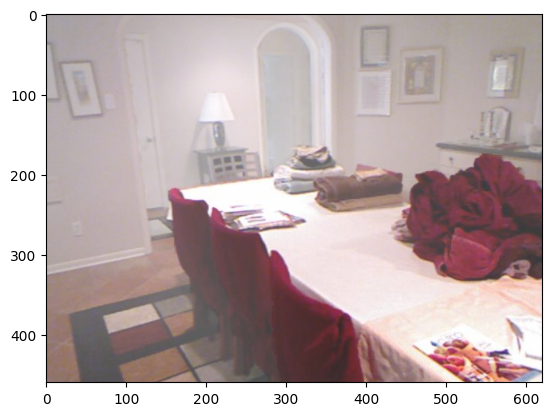

In [ ]:
plt.imshow(hazy)

In [ ]:
def dehaze_image(hazy_image, model, transform):
  mask_dummy = np.zeros_like(hazy_image)
  transformed = transform(image=hazy_image, mask=mask_dummy)
  #hazy = cv2.imread(image_hazy_path)
  #hazy = cv2.cvtColor(hazy, cv2.COLOR_BGR2RGB)
  hazy_image_transformed = transformed['image']
  model.eval()
  with torch.no_grad():
    hazy_image_tensor = torch.tensor(hazy_image_transformed).to(device).unsqueeze(0)
    model = model.to(device)
    #print(hazy_image.shape)
    pred_mask_tensor = model(hazy_image_tensor)
    #print(pred_mask_tensor.shape)
    pred_mask_tensor_final = torch.reshape(pred_mask_tensor, hazy_image_tensor.shape)
    #print(pred_mask_tensor_final.shape)
        #maxValue = np.amax(pred_masks_fod.detach().cpu().numpy())
        #minValue = np.amin(pred_masks_fod.detach().cpu().numpy())

    pred_mask = (np.clip(pred_mask_tensor_final.detach().cpu().squeeze(0).permute(1,2,0).numpy(), 0 , 1)*255).astype('uint8')
    #print(pred_mask.shape)
  return pred_mask

In [ ]:
dehazed = dehaze_image(hazy, best_model, test_transform)

<ipython-input-40-aa8f19a35889>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hazy_image_tensor = torch.tensor(hazy_image_transformed).to(device).unsqueeze(0)


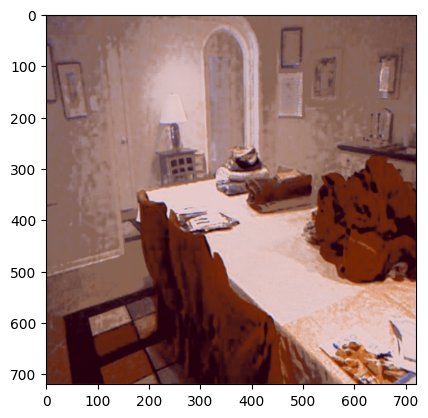

In [ ]:
plt.imshow(dehazed)

In [ ]:
!pip install -q gradio

In [ ]:
!pip install --upgrade gradio

In [ ]:
import gradio as gr

Dehazer = lambda hazy: dehaze_image(hazy, best_model, test_transform)

iface = gr.Interface(
    fn=Dehazer,
    inputs=gr.Image(label='Hazy Image'),
    outputs='image',
    live=True,
    title="Efface the haze - Demo",
    allow_flagging=False
)

iface.launch(share=True)


/usr/local/lib/python3.10/dist-packages/gradio/interface.py:374: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6820dc5c8ee1826338.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize

def calculate_psnr(original, dehazed):
    if original.shape != dehazed.shape:
        # Resize dehazed to match original
        dehazed = resize(dehazed, original.shape, preserve_range=True, anti_aliasing=True)
    return psnr(original, dehazed, data_range=255)

def calculate_ssim(original, dehazed):
    if original.shape != dehazed.shape:
        # Resize dehazed to match original
        dehazed = resize(dehazed, original.shape, preserve_range=True, anti_aliasing=True)
    return ssim(original, dehazed, multichannel=True, data_range=255)


In [ ]:
def dehaze_image(hazy_image, model, transform, original_image=None):
    # Apply transformation
    transformed = transform(image=hazy_image)
    hazy_image_transformed = transformed['image']

    # Check the data type and prepare the tensor for the model
    if isinstance(hazy_image_transformed, np.ndarray):
        # Convert NumPy array to tensor
        hazy_image_tensor = torch.from_numpy(hazy_image_transformed).float().to(device).unsqueeze(0)
    else:
        # If already a tensor, just clone and detach
        hazy_image_tensor = hazy_image_transformed.clone().detach().to(device).unsqueeze(0)

    # Model prediction
    model.eval()
    with torch.no_grad():
        pred_mask_tensor = model(hazy_image_tensor)
        pred_mask_tensor_final = torch.reshape(pred_mask_tensor, hazy_image_tensor.shape)
        pred_mask = (np.clip(pred_mask_tensor_final.detach().cpu().squeeze(0).permute(1, 2, 0).numpy(), 0, 1) * 255).astype('uint8')

    # Calculate and print PSNR and SSIM if the original image is provided
    if original_image is not None:
        psnr_value = calculate_psnr(original_image, pred_mask)
        ssim_value = calculate_ssim(original_image, pred_mask)
        print(f"PSNR: {psnr_value} dB, SSIM: {ssim_value}")

    return pred_mask


<ipython-input-27-b744893eb6d0>:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(original, dehazed, multichannel=True, data_range=255)


PSNR: 14.91527308246948 dB, SSIM: 0.7643901186863529


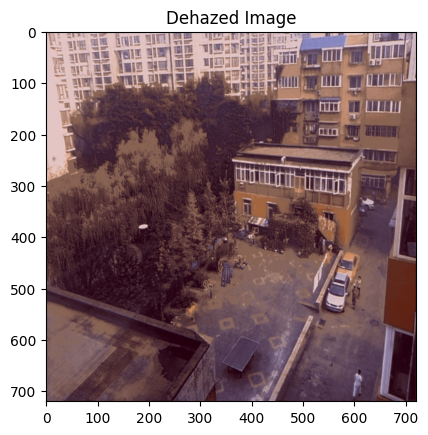

In [ ]:
# Load the original and hazy images
original_image = cv2.imread('/content/1945.png')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

hazy_image = cv2.imread('/content/1945_0.9_0.12.jpg')
hazy_image = cv2.cvtColor(hazy_image, cv2.COLOR_BGR2RGB)

# Dehaze and compute metrics
dehazed_image = dehaze_image(hazy_image, best_model, test_transform, original_image)

# Display the dehazed image
plt.imshow(dehazed_image)
plt.title("Dehazed Image")
plt.show()
